In [4]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import numpy as np
from orphics import io,stats,cosmology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
x = np.array([90,150,217,353,545,857])
ccon = cosmology.defaultConstants

def planck(nu_ghz,T):
    h = ccon['H_CGS']
    nu = 1e9*nu_ghz
    k = ccon['K_CGS']
    c = ccon['C']
    x = h*(nu)/(k*T)
    B = 2*h*nu**3.*(1./(np.exp(x)-1.))/c**2.
    return B


def dplanckT(nu_ghz):
    h = ccon['H_CGS']
    nu = 1e9*nu_ghz
    k = ccon['K_CGS']
    T = ccon['TCMB']
    c = ccon['C']
    x = h*(nu)/(k*T)
    dB = 2.*h**2.*nu**4.*(np.exp(x)/(np.exp(x)-1.)**2.)/c**2./k/T**2.
    return dB


def bdust(nu_ghz,z):
    nu0 = 353.
    beta = 1.78
    Tdust = 20.
    pref = (nu_ghz*(1+z)/nu0)**(beta)
    return pref * planck(nu_ghz*(1+z),Tdust) / dplanckT(nu_ghz)


def f_nu(nu):
    nu = np.asarray(nu)
    mu = ccon['H_CGS']*(1e9*nu)/(ccon['K_CGS']*ccon['TCMB'])
    ans = mu/np.tanh(mu/2.0) - 4.0
    return ans

zavg = 0.5
TCMB = 2.7255
def yflux(fghz,Yin):
    return TCMB*f_nu(fghz)*Yin
def dflux(fghz,Din):
    return bdust(fghz,zavg)*Din
def Sflux(fghz,Yin,Din,dT):
    #if Yin<0: return np.nan
    #if Din<0: return np.nan
    return yflux(fghz,Yin)+dflux(fghz,Din)+dT

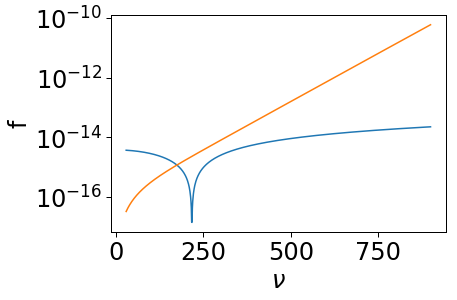

In [57]:
ffreqs = np.arange(30.,900.,1.)
Y = 7e-16
D = 3e-17
pl = io.Plotter(xlabel="$\\nu$",ylabel="f",yscale='log')
pl.add(ffreqs,np.abs(yflux(ffreqs,Y)))
pl.add(ffreqs,dflux(ffreqs,D))
pl.done()

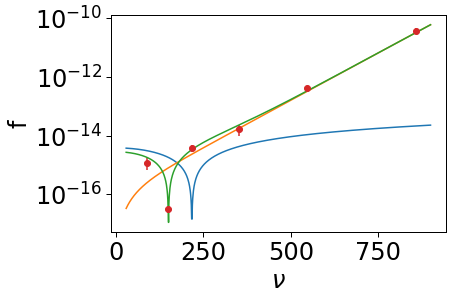

In [88]:
dT = 1e-15
ysyn = Sflux(x,Y,D,dT)
yerrs = 0.3*np.abs(ysyn)
ynoise = np.random.normal(0.,scale=yerrs)
ysyn += ynoise

pl = io.Plotter(xlabel="$\\nu$",ylabel="f",yscale='log')
pl.add(ffreqs,np.abs(yflux(ffreqs,Y)))
pl.add(ffreqs,dflux(ffreqs,D))
pl.add(ffreqs,np.abs(Sflux(ffreqs,Y,D,dT)))
pl.add_err(x,np.abs(ysyn),yerr=yerrs,marker="o",ls="none")
pl.done()


1e-15 7e-16 3e-17
[1.89859243e-16] [4.38565135e-16] [3.47895024e-17]
[0.25194136] [1.70780251] [5.73276029]
[[1.12363382]] [[0.3250963]]


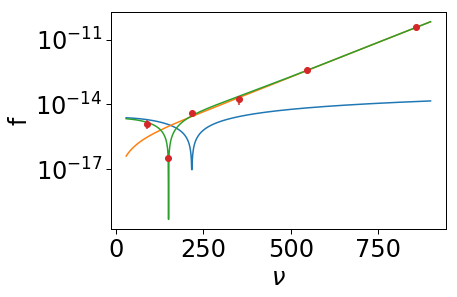

In [89]:
# x are the frequencies, ysyn are the measured fluxes
# we need to construct a diagonal covariance matrix from the known errors
# and we need to specify the three functions of x whose coefficients we want to fit for
bfit,bcov,chisquare,pte = stats.fit_linear_model(x,ysyn,ycov=np.diag(yerrs**2.),
                       funcs=[lambda x: 1.,lambda x: yflux(x,1.),lambda x: dflux(x,1.)])
dTfit,Yfit,Dfit = bfit
edTfit,eYfit,eDfit = np.sqrt(np.diagonal(bcov))


print(dT,Y,D)
print(dTfit,Yfit,Dfit)
print(dTfit/edTfit,Yfit/eYfit,Dfit/eDfit)
print(chisquare,pte)

pl = io.Plotter(xlabel="$\\nu$",ylabel="f",yscale='log')
pl.add(ffreqs,np.abs(yflux(ffreqs,Yfit[0])))
pl.add(ffreqs,dflux(ffreqs,Dfit[0]))
pl.add(ffreqs,np.abs(Sflux(ffreqs,Yfit[0],Dfit[0],dTfit[0])))
pl.add_err(x,np.abs(ysyn),yerr=yerrs,marker="o",ls="none")
pl.done()
